# Aeronautics & Astronautics Abstracts

Can a machine distinguish between propulsion and thermophysics abstracts? <br> 
https://www.kaggle.com/sylar68/aeronautics-astronautics-journal-abstracts

## Import the required libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
pd.options.mode.chained_assignment = None

# a library for cross-validation, hold out data split
from sklearn.model_selection import KFold, train_test_split

# a library for reading data and formatting information from Excel files
import xlrd

# libraries for text processing
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

# a data visualization library
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/elena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/elena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read data from excel

We download the aiaa_dataset.xls and store it in the INPUT_DATA_DIR as defined below

In [2]:
# define some information about where to get our data
INPUT_DATA_DIR = os.environ.get('INPUT_DATA_DIR', '/workspace/data/')

In [3]:
%%time
raw_df = pd.read_excel(os.path.join(INPUT_DATA_DIR, 'aero-astro-abstracts/aiaa_dataset.xls')) 
raw_df.head()

CPU times: user 23.9 ms, sys: 6.01 ms, total: 29.9 ms
Wall time: 62.7 ms


,title,abstract,journal,volume
0,Timescale-Based Frozen Nonadiabatic Flamelet C...,The present research work introduces a novel c...,JPP,37.4
1,Development and Testing of Liquid Simulants,A group of liquid simulants was developed in o...,JPP,37.4
2,Conjugate Analysis of Silica-Phenolic Charring...,Because of its excellent insulation capability...,JPP,37.4
3,Theoretical Analysis of Performance Parameters...,Conventional expressions and definitions descr...,JPP,37.4
4,Hurst Exponents for Intra- and Intercycle Ther...,"The detrended fluctuation analysis, a techniqu...",JPP,37.4


## Explore and preprocess the data

In [4]:
raw_df.shape

(493, 4)

In [5]:
# check out the columns with nulls
raw_df.isnull().any()

title       False
abstract    False
journal     False
volume      False
dtype: bool

In [6]:
# check out the duplicates and drop if exist
duplicated_rows = raw_df[raw_df.duplicated().values == True]
print(f'Number of duplicates: {len(duplicated_rows)}')

raw_df.drop_duplicates(inplace=True, ignore_index=False)
print(f'Shape of the data after removing duplicates {raw_df.shape}')

Number of duplicates: 1
Shape of the data after removing duplicates (492, 4)


In [7]:
# check unique values in columns
print('Number of unique values per column')
print(raw_df.nunique())
    
a = raw_df['volume'].unique()
a.sort()
print(f'\nUnique values in the volume column: {a}')

b = raw_df['journal'].unique()
print(f'\nUnique values in the journal column: {b}')

Number of unique values per column
title       474
abstract    474
journal       2
volume       25
dtype: int64

Unique values in the volume column: [33.1 33.2 33.3 33.4 34.1 34.2 34.3 34.4 34.5 35.1 35.2 35.3 35.4 35.5
 35.6 36.1 36.2 36.3 36.4 36.5 36.6 37.1 37.2 37.3 37.4]

Unique values in the journal column: ['JPP' 'JTHT']


We see that title and abstract columns have 474 unique values while the total number of rows is 492. We look at the repeated values of titles and abstracts

In [8]:
similar_rows = raw_df[
    np.logical_and(
        (raw_df['title'].duplicated().values == True), 
        (raw_df['abstract'].duplicated().values == True),
        (raw_df['journal'].duplicated().values == True)
    )
]

raw_df[raw_df['title'].isin(similar_rows['title'].tolist())].sort_values(by='title')

,title,abstract,journal,volume
314,Analysis on Fluid-Induced Vibration and Heat T...,The study on fluid-induced vibration of helica...,JTHT,34.5
296,Analysis on Fluid-Induced Vibration and Heat T...,The study on fluid-induced vibration of helica...,JTHT,35.1
301,Effect of Flow Normalization in Micro-Pin-Finn...,The micro-pin-fin heat sink (MPFHS) is widely ...,JTHT,34.5
283,Effect of Flow Normalization in Micro-Pin-Finn...,The micro-pin-fin heat sink (MPFHS) is widely ...,JTHT,35.1
286,Effect of Insulations and Coatings on Hyperson...,The present study investigates the effects of ...,JTHT,35.1
304,Effect of Insulations and Coatings on Hyperson...,The present study investigates the effects of ...,JTHT,34.5
309,Enhanced Mixed Convection in a Vertical Channe...,"In this Paper, two-dimensional unsteady lamina...",JTHT,34.5
291,Enhanced Mixed Convection in a Vertical Channe...,"In this Paper, two-dimensional unsteady lamina...",JTHT,35.1
312,Enhancement of the Hydrothermal Characteristic...,Geometrical configurations of tubes and vortex...,JTHT,34.5
294,Enhancement of the Hydrothermal Characteristic...,Geometrical configurations of tubes and vortex...,JTHT,35.1


Values of the title, abstract and journal are repeated in the subset above. The only difference is volume (35.1/34.5). We can remove the similar rows because the information important for the task is in the first 3 columns

In [9]:
raw_df.drop(similar_rows.index, inplace=True)
raw_df[raw_df['title'].isin(similar_rows['title'].tolist())].sort_values(by='title')

,title,abstract,journal,volume
296,Analysis on Fluid-Induced Vibration and Heat T...,The study on fluid-induced vibration of helica...,JTHT,35.1
283,Effect of Flow Normalization in Micro-Pin-Finn...,The micro-pin-fin heat sink (MPFHS) is widely ...,JTHT,35.1
286,Effect of Insulations and Coatings on Hyperson...,The present study investigates the effects of ...,JTHT,35.1
291,Enhanced Mixed Convection in a Vertical Channe...,"In this Paper, two-dimensional unsteady lamina...",JTHT,35.1
294,Enhancement of the Hydrothermal Characteristic...,Geometrical configurations of tubes and vortex...,JTHT,35.1
290,Experimental Evaluation of the Long-Wave Infra...,An experimental method is reported for the eva...,JTHT,35.1
297,Experimental Investigation of the Performance ...,To decrease the heating and cooling demand of ...,JTHT,35.1
285,Flow and Mass Transfer of Pyrolytic Aviation K...,Surface coking is significantly affected by th...,JTHT,35.1
287,Forward and Inverse Analyses of Two-Dimensiona...,Heat transfer under space restriction is a cha...,JTHT,35.1
298,Global Sensitivity Analysis Based on BP Neural...,In order to obtain the thermal design paramete...,JTHT,35.1


## Split data and leave the test data only for testing
We will retrieve a text vocabulary only from the training data and the test data will remain unseen for our model

In [10]:
raw_df_train, raw_df_test = train_test_split(raw_df, test_size=0.2, stratify=raw_df['journal'])
raw_df_test.shape

(95, 4)

## Retrieve vocabulary from text data using Natural Language Toolkit
@ Steven Bird, Ewan Klein, and Edward Loper (2009). Natural Language Processing with Python. O’Reilly Media Inc. https://www.nltk.org/book

We will explore vocabulary of each type of journals

In [11]:
# retrieve combined text as well as text per each journal
raw_df_train.loc[:, 'text'] = raw_df_train.loc[:, 'title'] + ' ' + raw_df_train.loc[:, 'abstract']
text_data = raw_df_train.loc[:, 'text'].tolist()

text_jpp = raw_df_train.loc[raw_df_train['journal'] == 'JPP', 'text'].tolist()
text_jtht = raw_df_train.loc[raw_df_train['journal'] == 'JTHT', 'text'].tolist()

In [12]:
# we transform text into lowercase, split it into sentences and then into word tokens
tokens_all = nltk.word_tokenize(' '.join(nltk.sent_tokenize(' '.join(text_data).lower())))
tokens_jpp = nltk.word_tokenize(' '.join(nltk.sent_tokenize(' '.join(text_jpp).lower())))
tokens_jtht = nltk.word_tokenize(' '.join(nltk.sent_tokenize(' '.join(text_jtht).lower())))

vocabulary_all = sorted(set(tokens_all))
vocabulary_jpp = sorted(set(tokens_jpp))
vocabulary_jtht = sorted(set(tokens_jtht))

print(f'Size of full vocabulary: {len(vocabulary_all)}')
print(f'Size of JPP vocabulary: {len(vocabulary_jpp)}')
print(f'Size of JTHT vocabulary: {len(vocabulary_jtht)}')


Size of full vocabulary: 7275
Size of JPP vocabulary: 4957
Size of JTHT vocabulary: 4644


In [13]:
# select vocabulary common for both journals 
vocabulary_common = [x for x in vocabulary_jpp if x in vocabulary_jtht]

# as well as the specific vocabulary per each journal
vocabulary_jpp_unique = [x for x in vocabulary_jpp if x not in vocabulary_common]
vocabulary_jtht_unique = [x for x in vocabulary_jtht if x not in vocabulary_common]

print(f'Number of common tokens: {len(vocabulary_common)}')
print(f'Number of JPP specific tokens: {len(vocabulary_jpp_unique)}')
print(f'Number of JTHT specific tokens:  {len(vocabulary_jtht_unique)}')

Number of common tokens: 2326
Number of JPP specific tokens: 2631
Number of JTHT specific tokens:  2318


## Find the most frequent tokens unique for the each type of journal

In [14]:
word_freq_jpp = nltk.FreqDist(w for w in tokens_jpp if w not in vocabulary_common)
word_freq_jtht = nltk.FreqDist(w for w in tokens_jtht if w not in vocabulary_common)

def print_most_frequent_words(n_words = 30):
    
    print(f'The most frequent {n_words} words unique per type of journal\n')
    print(f'JPP journal: \n{list(word_freq_jpp)[:30]}\n')
    print(f'JTHT journal: \n{list(word_freq_jtht)[:30]}')
    
print_most_frequent_words()

The most frequent 30 words unique per type of journal

JPP journal: 
['thrust', 'ignition', 'detonation', 'injector', 'combustor', 'burning', 'oxidizer', 'ion', 'release', 'hall', 'thrusters', 'stability', 'stall', 'hypergolic', 'motors', 'acoustic', 'gaseous', 'injectors', 'rde', 'ap', 'anode', 'firing', 'peroxide', 'aging', 'distortion', 'burn', 'xenon', 'stabilization', 'boron', 'delays']

JTHT journal: 
['convection', 'nusselt', 'hypersonic', 'conductivity', 'vibration', 'enclosure', 'nanofluid', 'nanofluids', 'vibrational', 'microchannels', 'dissociation', 'recombination', 'fluids', 'dissipation', 'lhp', 'protection', 'knudsen', 'solve', 'exchanger', 'pid', 'sink', 'height', 'darcy', 'atomic', 'microchannel', 'friction', 'environmental', 'reentry', 'shock-tube', 'boyle']


## Text Data Cleaning
Let's remove stop words, punctuation, numbers, single sybmol words and arithmetic expressions from the  vocabulary

In [15]:
# remove stop words, punctuation
words_to_remove = set(stopwords.words('english') + list(string.punctuation))

filtered_vocabulary_all = [
    word for word in vocabulary_all if word not in words_to_remove
]

# remove numbers and arithmetic expressions
pattern_numbers_and_expressions = re.compile('[±×−∼–-]?[0-9]\d*[×±=.,/−∼–-∶]?\d*[×±=.,/−∼–-∶]?')
pattern_letters_and_numbers = re.compile('[A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*')

filtered_vocabulary_all =[
    word for word in filtered_vocabulary_all if not (
        pattern_numbers_and_expressions.match(word)
        or pattern_letters_and_numbers.match(word)
        or '=' in word
    )
]

# remove leading and trailing special characters
filtered_vocabulary_all = [w.strip("'./*∗-′+®`") for w in filtered_vocabulary_all]

# remove words with only one symbol
# filtered_vocabulary_all = list(filter(lambda x: (len(x) > 1), filtered_vocabulary_all)) 

filtered_tokens_all = [t for t in tokens_all if t in filtered_vocabulary_all]
filtered_tokens_jpp = [t for t in tokens_jpp if t in filtered_vocabulary_all]
filtered_tokens_jtht = [t for t in tokens_jtht if t in filtered_vocabulary_all]

## Frequency distribution of tokens

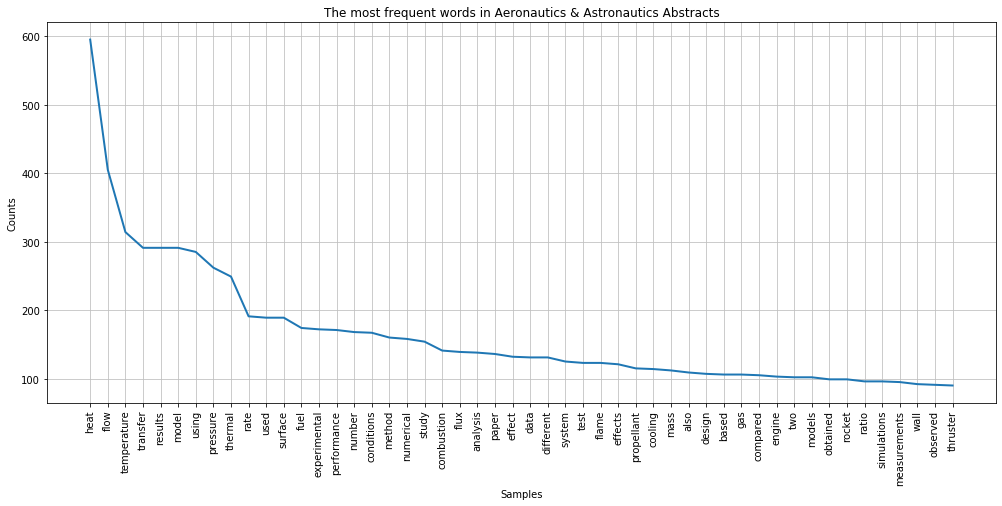

In [16]:
freq_tokens_all = nltk.FreqDist(filtered_tokens_all)

plt.figure(figsize=(17, 7))
freq_tokens_all.plot(50, title='The most frequent words in Aeronautics & Astronautics Abstracts')

## Find collocations
A collocation is a series of words or terms that co-occur more often than would be expected by chance. They can be play an important role in distinguishing between domains

In [17]:
bigram_frequency_creteria = 5
max_number_allocations = 1000

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(filtered_tokens_all)
finder.apply_freq_filter(bigram_frequency_creteria)

bigram_collocation = finder.nbest(bigram_measures.likelihood_ratio, max_number_allocations)

print(len(bigram_collocation))
print(bigram_collocation[0:10])

487
[('heat', 'transfer'), ('heat', 'flux'), ('’', 's'), ('magnetic', 'field'), ('rotating', 'detonation'), ('thermal', 'conductivity'), ('fluid', 'dynamics'), ('computational', 'fluid'), ('results', 'show'), ('boundary', 'layer')]


In [18]:
trigram_frequency_creteria = 3
max_number_allocations = 500

trigram_measures = TrigramAssocMeasures()

finder = TrigramCollocationFinder.from_words(filtered_tokens_all)
finder.apply_freq_filter(trigram_frequency_creteria)

trigram_collocation = finder.nbest(trigram_measures.likelihood_ratio, max_number_allocations)

print(len(trigram_collocation))
print(trigram_collocation[:10])

302
[('heat', 'transfer', 'coefficient'), ('heat', 'transfer', 'enhancement'), ('convective', 'heat', 'transfer'), ('heat', 'transfer', 'rate'), ('radiative', 'heat', 'transfer'), ('heat', 'transfer', 'helical'), ('enhance', 'heat', 'transfer'), ('wall', 'heat', 'transfer'), ('surface', 'heat', 'transfer'), ('heat', 'transfer', 'characteristics')]


## Feature engineering for NaiveBayesClassifier

In [19]:
# transform collocations from tuples to string units and store them in lists
bigram_collocation = [' '.join(collocation) for collocation in bigram_collocation]
trigram_collocation = [' '.join(collocation) for collocation in trigram_collocation]

# create vocabulary of collocations
collocations_vocabulary = bigram_collocation
collocations_vocabulary.extend(trigram_collocation)

print(bigram_collocation[:5])
print(trigram_collocation[:5])

['heat transfer', 'heat flux', '’ s', 'magnetic field', 'rotating detonation']
['heat transfer coefficient', 'heat transfer enhancement', 'convective heat transfer', 'heat transfer rate', 'radiative heat transfer']


In [20]:
# get n most frequent vocabulary tokens
def get_vocabulary(tokens: list, n = 2000):

    vocabulary = tokens[:n] if len(tokens) >= n else tokens
    return vocabulary

# create vocabulary of tokens
ordered_tokens = list(freq_tokens_all)
tokens_vocabulary = get_vocabulary(ordered_tokens, len(ordered_tokens))

print(f'Size of vocabulary of tokens: {len(tokens_vocabulary)}')
print(f'Size of vocabulary of collocations: {len(collocations_vocabulary)}')

Size of vocabulary of tokens: 6371
Size of vocabulary of collocations: 789


In [21]:
# get document features in a form of dictionary 
# where key contains a token name and value tells whether the token is present in the document
def get_document_features(
    document_tokens, 
    document_text,
    tokens = tokens_vocabulary, 
    collocations = collocations_vocabulary
):
    unique_document_tokens = set(document_tokens)
    
    features = {}
    for word in tokens:
        features['contains({})'.format(word)] = (word in unique_document_tokens)
        
    for collocation in collocations:
        features['contains({})'.format(collocation)] = (collocation in document_text)
        
    return features

# create features for each type of journals of the TRAINING set
features_jpp_train = [
    (
        get_document_features(
            nltk.word_tokenize(' '.join(nltk.sent_tokenize(d.lower()))), d
        ), 'JPP'
    ) for d in text_jpp
]

features_jtht_train = [
    (
        get_document_features(
            nltk.word_tokenize(' '.join(nltk.sent_tokenize(d.lower()))), d
        ), 'JTHT'
    ) for d in text_jtht
]

documents_features_train = features_jpp_train + features_jtht_train
random.shuffle(documents_features_train)

print(f'Check number of documents features in the training set: {len(documents_features_train)}')

Check number of documents features in the training set: 379


In [22]:
# create features for each type of journals of the TESTING set
raw_df_test.loc[:, 'text'] = raw_df_test.loc[:, 'title'] + ' ' + raw_df_test.loc[:, 'abstract']

text_jpp_test = raw_df_test.loc[raw_df_test['journal'] == 'JPP', 'text'].tolist()
text_jtht_test = raw_df_test.loc[raw_df_test['journal'] == 'JTHT', 'text'].tolist()


features_jpp_test = [
    (
        get_document_features(
            nltk.word_tokenize(' '.join(nltk.sent_tokenize(d.lower()))), d
        ), 'JPP'
    ) for d in text_jpp_test
]

features_jtht_test = [
    (
        get_document_features(
            nltk.word_tokenize(' '.join(nltk.sent_tokenize(d.lower()))), d
        ), 'JTHT'
    ) for d in text_jtht_test
]

documents_features_test = features_jpp_test + features_jtht_test
random.shuffle(documents_features_test)

print(f'Check number of documents features in the testing set: {len(documents_features_test)}')

Check number of documents features in the testing set: 95


## Classify entries with NaiveBayesClassifier and KFold cross-validation
I use cross-validation to try different parameters for bigram and trigram_frequency_creteria, max_number_allocations and tokens vocabulary size. Then I test the model on unseen data

In [23]:
num_folds = 10

training_accuracy = []
validation_accuracy = []

skf = KFold(n_splits=num_folds, shuffle=True)

for train_index, validation_index in skf.split(documents_features_train):
    
    train_set = [documents_features_train[i] for i in train_index]
    validation_set = [documents_features_train[i] for i in validation_index]
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    
    training_accuracy.append(nltk.classify.accuracy(classifier, train_set))
    validation_accuracy.append(nltk.classify.accuracy(classifier, validation_set))

In [24]:
print(f'Accuracy of train data: {sum(training_accuracy)/len(training_accuracy)}')
print(f'Accuracy of validation data: {sum(validation_accuracy)/len(validation_accuracy)}')

Accuracy of train data: 0.9964826533587144
Accuracy of validation data: 0.9152916073968707


## Test on the testing dataset

In [25]:
classifier = nltk.NaiveBayesClassifier.train(documents_features_train)

testing_accuracy = nltk.classify.accuracy(classifier, documents_features_test)
print(f'Accuracy of test data: {testing_accuracy}')

Accuracy of test data: 0.9473684210526315


## Error Analysis 
Analyse documents with wrong predictions

In [28]:
# get document features for test in the initial order
documents_features_test = features_jpp_test + features_jtht_test

wrong_predictions_indexes = []

for index, document in enumerate(documents_features_test):
    features, journal_type = document
    journal_type_predicted = classifier.classify(features)
    if journal_type != journal_type_predicted:
        wrong_predictions_indexes.append(index)

n = len(text_jpp_test)
for index in wrong_predictions_indexes:
    if index < n:
        print(f'JPP document: {text_jpp_test[index]}\n')
    else:
        print(f'JTHT document: {text_jtht_test[index - n]}\n')

JPP document: Numerical Simulation of Rotor-Stator Interaction Noise in Transonic Cascades The first objective of this work is the verification of a moving-body immersed boundary method for the direct computation of noise generated by rotor-stator interactions in transonic 2-D cascades. This method is based on a discrete forcing approach where the boundary conditions are directly imposed at the surface of moving and static cascades immersed in a domain discretized by a regular Cartesian grid. The numerical method is verified using the mode generation and propagation theory applied to thin annular ducts for two-dimensional cascades. Two cases are simulated, the rotor alone and the rotor-stator interaction. For the first case, all computed modes are generated following the Tyler-Sofrin rule, but none of them are cut-on, as predicted by the duct propagation theory. For the second case, all modes are also generated in accordance with that rule, and the numerical results for the cut-on mode

## Most Informative Features
Both tokens and collocations play important role in predicting the domain

In [27]:
classifier.show_most_informative_features(50)

Most Informative Features
    contains(combustion) = True              JPP : JTHT   =     18.0 : 1.0
      contains(thruster) = True              JPP : JTHT   =     17.7 : 1.0
       contains(impulse) = True              JPP : JTHT   =     15.7 : 1.0
         contains(fuels) = True              JPP : JTHT   =     14.5 : 1.0
contains(nonequilibrium) = True             JTHT : JPP    =     14.2 : 1.0
    contains(conduction) = True             JTHT : JPP    =     12.1 : 1.0
     contains(discharge) = True              JPP : JTHT   =     11.9 : 1.0
       contains(chamber) = True              JPP : JTHT   =     11.4 : 1.0
    contains(propulsion) = True              JPP : JTHT   =     11.4 : 1.0
contains(combustion chamber) = True              JPP : JTHT   =     11.2 : 1.0
    contains(regression) = True              JPP : JTHT   =     11.2 : 1.0
          contains(fuel) = True              JPP : JTHT   =     11.0 : 1.0
    contains(propellant) = True              JPP : JTHT   =     10.9 :